# Applied Time Series Analysis of Bike Accidents in Madrid

# Intro
I recently came across a dataset containing registered accidents involving a bicycle, and as a data scientist who enjoys an occasional ride around my city this seemed like a good opportunity to have fun with this data.


To be more precise, the data forms a time series ranging from 2010 to 2018 with accidents registered chronologically by the Police, and is openly supplied by the City of Madrid in the link below. Several variables are also available such as location, weather or road conditions, but we will leave those out for other type of analysis and focus on the time series.

https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=20f4a87ebb65b510VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

By analyzing this dataset we can provide insights to the City of Madrid to understand the dangers for bicycle users and eventually make it a safer city for them.

(Data from 2010 - 2018, schemas and potentially the way data is captured changes from 2019)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.seasonal import STL
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsoluteError

pd.options.display.max_rows = 400
pd.options.display.max_columns = 300
pd.set_option('display.max_colwidth', 255)

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Process data

In [6]:
years = range(2010, 2018)
path = r"..\AccidentesBicicletas_"
bicis_df = pd.DataFrame()

for year in years:
    year_df = pd.read_csv(f"{path}{year}.csv", delimiter=";")
    year_df["year"] = year
    bicis_df = pd.concat([bicis_df, year_df])

In [7]:
bicis_df = bicis_df[~bicis_df.FECHA.isnull()]
bicis_df = bicis_df.reindex()

bicis_df["Hour"] = bicis_df["RANGO HORARIO"].str.replace("DE ", "").apply(lambda x: x.split(" ")[0])
bicis_df["Date"] = bicis_df["FECHA"] + " " + bicis_df["Hour"]
bicis_df["Date"] = pd.to_datetime(bicis_df.Date, format="%d/%m/%Y %H:%M")

In [6]:
bicis_df.head()

,FECHA,RANGO HORARIO,DIA SEMANA,DISTRITO,LUGAR ACCIDENTE,N�,N� PARTE,CPFA Granizo,CPFA Hielo,CPFA Lluvia,CPFA Niebla,CPFA Seco,CPFA Nieve,CPSV Mojada,CPSV Aceite,CPSV Barro,CPSV Grava Suelta,CPSV Hielo,CPSV Seca Y Limpia,N� VICTIMAS *,TIPO ACCIDENTE,Tipo Vehiculo,TIPO PERSONA,SEXO,LESIVIDAD,Tramo Edad,year,Hour,Date
0,05/01/2010,DE 17:00 A 17:59,MARTES,VILLAVERDE,PASEO DE LOS TALLERES NUM,3,2010/112,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,SI,1.0,COLISI�N DOBLE,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 55 A 59 A�OS,2010,17:00,2010-01-05 17:00:00
1,10/01/2010,DE 15:00 A 15:59,DOMINGO,CIUDAD LINEAL,CALLE DE ARTURO SORIA NUM,316,2010/523,NO,NO,NO,NO,SI,NO,SI,NO,NO,NO,NO,NO,1.0,COLISI�N DOBLE,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 65 A 69 A�OS,2010,15:00,2010-01-10 15:00:00
2,14/01/2010,DE 14:00 A 14:59,JUEVES,TETUAN,PASEO DE LA CASTELLANA NUM,95,2010/582,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,SI,1.0,CA�DA BICICLETA,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 40 A 44 A�OS,2010,14:00,2010-01-14 14:00:00
3,17/01/2010,DE 14:00 A 14:59,DOMINGO,VILLAVERDE,CALLE DE ALCOCER - CALLE DE ARECHAVALETA,0,2010/494,NO,NO,SI,NO,NO,NO,SI,NO,NO,NO,NO,NO,1.0,COLISI�N DOBLE,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 35 A 39 A�OS,2010,14:00,2010-01-17 14:00:00
4,18/01/2010,DE 19:00 A 19:59,LUNES,ARGANZUELA,PASEO DE PONTONES NUM,18,2010/708,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,SI,1.0,COLISI�N DOBLE,BICICLETA,CONDUCTOR,HOMBRE,HL,DE 25 A 29 A�OS,2010,19:00,2010-01-18 19:00:00


## Intermittent Time Series

In [8]:
dates_freq = bicis_df.FECHA.value_counts().reset_index()
dates_freq.columns = ["date", "freq"]

dates_freq["date"] = pd.to_datetime(dates_freq["date"], format="%d/%m/%Y")
dates_freq = dates_freq.sort_values("date")

In [9]:
timeseries = pd.Series(dates_freq.freq.tolist(), dates_freq.date)
timeseries = timeseries.asfreq('d')
timeseries = timeseries.fillna(0)

In [10]:
timeseries_month = timeseries.reset_index()
timeseries_month["dummy"] = "dummy"
timeseries_month = timeseries_month.groupby(["dummy", pd.Grouper(key='date', freq='M')])[0].sum()
timeseries_month = timeseries_month.reset_index(0, drop=True)

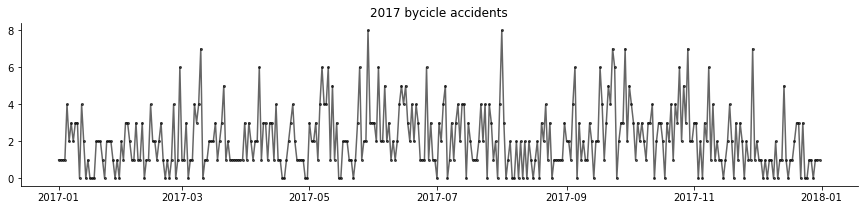

In [125]:
plt.figure(figsize=(15,3))
plt.title("2017 bycicle accidents")
plt.plot(timeseries.tail(365), c="black", alpha=0.6, marker="o", markersize="2")

We are facing a particular type of time series called intermittent time series where a significant proportion of the values are zero, often as in this case the data comes from counts.

These series present additional complexity since many of the most commonly used Time Series Analysis methods assume a constant or a non-zero variable.

For this reason we will be using Croston's method, this method was devised by J. D. Croston in 1970 to forecast demand of intermittent stock and to this day is still heavily used, we will dive deeper into it as the blog moves on.

## Time Series Decomposition

To improve our understanding of the data we will start off with a time series decomposition.

Based on the nature of the data, there are two types of seasonality that we would expect:

- Yearly seasonality. We can expect a cyclic pattern repeating on a yearly basis due to the influence of good and bad weather.
- Weekly seasonality. We might observe a different pattern influenced by working days and weekends that could affect the number of bicycle users, their routes and other behavior. This could lead to a better understanding of cyclists' behavior and spark further analysis, for example do we need to pay more attention to cyclists during workdays because most accidents take place on the road to work?

### Yearly decomposition
To reduce the complexity of dealing with an intermittent series we aggregate the series by monthly frequency, this also gives us a smoother and less noisy overview.

We will use an STL decomposition, Seasonal and Trend decomposition using LOESS, this is a robust method to perform time series decomposition, it also allows the seasonal component to evolve over time. Underneath, it uses LOESS, a non-parametric method using polynomial regression to fit a smooth curve to a target variable.

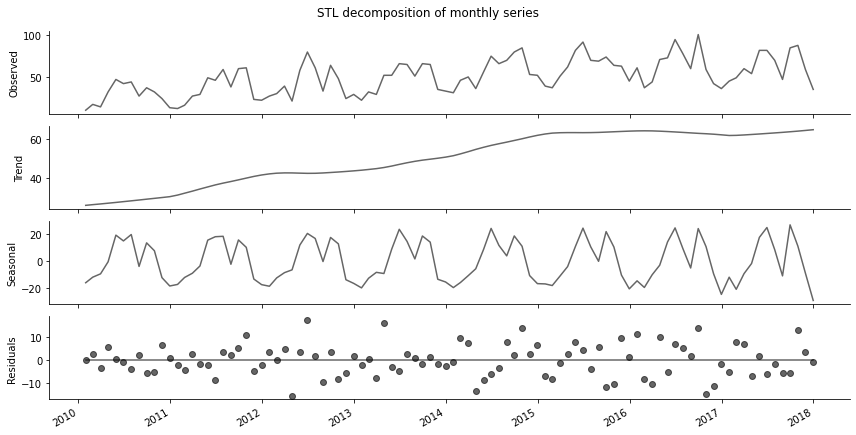

In [168]:
decomposition = STL(timeseries_month, period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,7))
fig.suptitle('STL decomposition of monthly series')
ax1.plot(decomposition.observed, c="black", alpha=0.6)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend, c="black", alpha=0.6)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal, c="black", alpha=0.6)
ax3.set_ylabel('Seasonal')
ax4.scatter(timeseries_month.index, decomposition.resid, c="black", alpha=0.6)
ax4.plot(timeseries_month.index, [0]*len(timeseries_month), c="black", alpha=0.6)
ax4.set_ylabel('Residuals')
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

In [41]:
seasonal = result.seasonal.reset_index()
seasonal["month"] = seasonal["date"].dt.strftime("%B")
seasonal["year"] = seasonal["date"].dt.year

seasonal_summer = seasonal[seasonal["month"].isin(["May", "June", "July", "August", "September", "October"])]

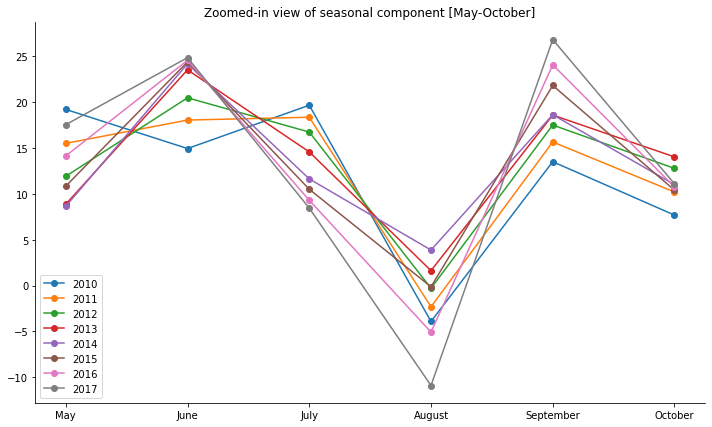

In [42]:
plt.figure(figsize=(12,7))
for year in range(2010, 2018):
    seasonal_summer_year = seasonal_summer[seasonal_summer["year"] == year]
    plt.plot(seasonal_summer_year.month, seasonal_summer_year.season, marker="o", label=year)
plt.title("Zoomed-in view of seasonal component [May-October]")
plt.legend()
plt.show()

- We can observe a growing trend in accidents that has flattened for the last three years which can be a positive sign if our goal is to make the city safer for cyclists.
- The seasonal component shows a similar pattern year after year with an interesting shape, peaking in June/July and September and dropping in August. We can hypothesize that during summer good weather favors bicycle usage and perhaps the explanation for the trough in August is that many locals leave Madrid during that month to go on holidays.

## Outliers

In [43]:
residuals = result.resid

spread = 1.5
q3, q1 = np.percentile(residuals, [75, 25])
iqr = q3 - q1
upper_bound = q3 + spread * iqr
lower_bound = q1 - spread * iqr

In [44]:
outliers = residuals[(residuals > upper_bound) | (residuals < lower_bound)]
outliers

date
2012-06-30    17.125283
Freq: M, Name: resid, dtype: float64

[]

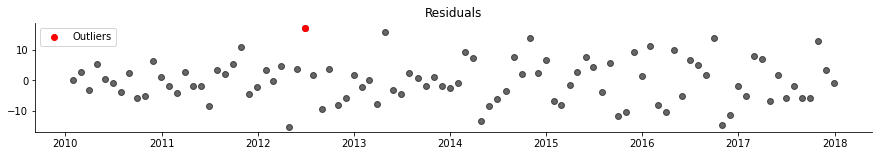

In [70]:
plt.figure(figsize=(15,2))
plt.scatter(residuals.index, residuals,c="black", alpha=0.6)
plt.scatter(outliers.index, outliers, c="r", label="Outliers")
plt.title(f"Residuals")
plt.legend(loc='upper left')
plt.plot()

The analysis of past outliers can be useful to highlight an extraordinary spike in bike accidents and for example evidence a combination of an special time event with a problematic location and/or weather conditions, this information can be used by the authorities to enforce mitigation actions preventing future accidents.

Using the previous monthly decomposition, we search for outliers by looking into the distribution of the residuals.
We declare as an outlier any residual that is above 1.5 times the IQR, this is 1.5 times the range between the 25 and the 75 percentiles of the distribution.

This results in a single outlier in June 2021, however, in this case I can not find through other variables in the data or other news sources anything abnormal like a spell of  bad weather, or a special event held in Madrid during that period that could shed more light on this outlier.

#### June 2012 outlier analysis

In [75]:
june2012_df = bicis_df[(bicis_df["Date"] > pd.to_datetime("01/06/2012", dayfirst=True))
                       & (bicis_df["Date"] <= pd.to_datetime("30/06/2012"))]

In [77]:
june2012_df.shape

(77, 29)

In [ ]:
june2012_df.head()

In [ ]:
#june2012_df["TIPO ACCIDENTE"].value_counts()
#june2012_df["CPSV Seca Y Limpia"].value_counts()
#june2012_df["CPFA Seco"].value_counts()
#june2012_df["DIA SEMANA"].value_counts()
#june2012_df.FECHA.value_counts().head()
#june2012_df.DISTRITO.value_counts()

# june2012_df[june2012_df["TIPO ACCIDENTE"] == "ATROPELLO                               "]
# june2012_df[june2012_df["TIPO ACCIDENTE"].str.startswith("CA")]
# june2012_df[june2012_df["TIPO ACCIDENTE"].str.rstrip().str.endswith("PLE")]

## Forecasting with Croston's method

Forecasting can be used by the authorities to anticipate sufficient resources to support accidents, operationally this could be even more effective by targeting smaller portions of the city, for example by having a forecast for each of the regions where a Police station operates.

We will continue using Croston's method. Rather than predicting when exactly an accident will happen or not, Croston's forecasts the demand and intervals without demand and predicts an averaged demand for a period. In this case we do not need to know precisely if tomorrow there will be zero, one or more accidents, Police staffing support is probably decided at most on a weekly or monthly basis, so working with an average demand is fine.

We pick a test dataset consisting of two weeks and obtain the below results.

In [207]:
# Adapted from https://github.com/sktime/sktime/blob/main/sktime/forecasting/croston.py
def croston(timeseries, h=1, smoothing=0.1):
    dates = timeseries.index.to_list()
    timeseries = timeseries.to_numpy()
    time_periods = len(timeseries)
    timeseries = np.concatenate((timeseries,[np.nan]*h))
    
    # demand(q), interval(a), forecast(f)
    q, a, f, interval = np.full((4, time_periods + h), np.nan)
    p = 1  # periods since last demand observation

    # Initialization:
    first_occurrence = np.argmax(timeseries[:time_periods] > 0)
    q[0] = timeseries[first_occurrence]
    a[0] = 1 + first_occurrence
    f[0] = q[0] / a[0]
    interval[0] = p

    # Create forecasts:
    for t in range(0, time_periods):
        if timeseries[t] > 0:
            q[t+1] = smoothing * timeseries[t] + (1-smoothing) * q[t]
            a[t+1] = smoothing * p + (1-smoothing) * a[t]
            f[t+1] = q[t+1] / a[t+1]  # Average demand for that interval
            p = 1
            interval[t+1] = p

        else:  # If no demand, all forecasts stay the same
            q[t+1] = q[t]
            a[t+1] = a[t]
            f[t+1] = f[t]
            p += 1
            interval[t+1] = p

    # Extend forecast
    q[time_periods+1:time_periods+h] = q[time_periods]
    a[time_periods+1:time_periods+h] = a[time_periods]
    f[time_periods+1:time_periods+h] = f[time_periods]
    
    croston_df = pd.DataFrame.from_dict({"Observed":timeseries,"Interval":interval,"Forecast":f,"Period":a,"Demand":q})
    croston_df.index = dates + [dates[-1] + pd.Timedelta(days=_+1) for _ in range(h)]
    croston_df.index.name = "date"
    return croston_df

In [290]:
period_forecast = 14

train_df = timeseries[:-period_forecast]
test_df = timeseries[-period_forecast:]

In [291]:
croston_df = croston(train_df, h=period_forecast, smoothing=0.1)
croston_df.tail(10)

,Observed,Interval,Forecast,Period,Demand
date,,,,,
2017-12-22,NaN,NaN,1.332133,1.361129,1.813205
2017-12-23,NaN,NaN,1.332133,1.361129,1.813205
2017-12-24,NaN,NaN,1.332133,1.361129,1.813205
2017-12-25,NaN,NaN,1.332133,1.361129,1.813205
2017-12-26,NaN,NaN,1.332133,1.361129,1.813205
2017-12-27,NaN,NaN,1.332133,1.361129,1.813205
2017-12-28,NaN,NaN,1.332133,1.361129,1.813205
2017-12-29,NaN,NaN,1.332133,1.361129,1.813205
2017-12-30,NaN,NaN,1.332133,1.361129,1.813205


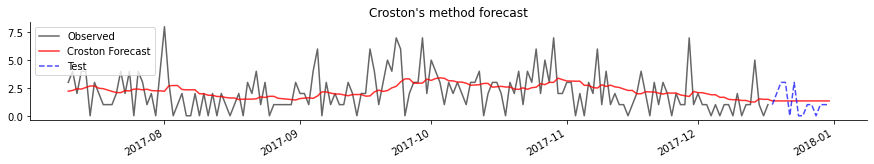

In [297]:
n = 7 * 25

fig = plt.figure(figsize=(15,2))
plt.plot(croston_df.Observed[-n:], color="black", alpha=0.6, label="Observed")
plt.plot(croston_df.Forecast[-n:], color="red", alpha=0.8, label="Croston Forecast")
plt.plot(test_df, color="blue", alpha=0.7, linestyle="--", label="Test")

fig.autofmt_xdate()
plt.title("Croston's method forecast")
plt.legend(loc='upper left')
plt.show()

In [293]:
y_pred = croston_df.Forecast[-period_forecast:]

mae = MeanAbsoluteError()
mase = MeanAbsoluteScaledError()

In [ ]:
mae(test_df, y_pred)  # 0.92

In [ ]:
mase(test_df, y_pred, y_train=train_df)  # 0.65

Since we have intermittent data that includes zero values we have to be specially careful when selecting the metric to measure the model performance.

- We could use the mean absolute error, MAE, however if for example we want to develop a weekly model we would not be able to fairly compare their performance because the metric will be dependent on the scale of the data.
- Mean absolute percentage error, MAPE, offers a relative metric, however due to the intermittent data we would incur in a division by zero.
- Mean Absolute Scaled Error, MASE, circumvents these issues, it is a robust metric for intermittent series and it gives us a scale-free metric based on the ratio between the prediction error and the error from a naive model that predicts the previous timestamp.

Our prediction is 1.33 for the two weeks, and the model obtains a MAE of 0.92 and a MASE of 0.65. This can be interpreted as on average the model is almost off by 1 accident due to over or underestimation, and the MASE tells us that the model outperforms the baseline of a naive prediction.

I encourage the reader to explore other Croston's variants like SBA or TSB to improve these results.

### Croston's Series Decomposition

### Weekly decomposition
In this case, we are not able to use the same trick as we did before by aggregating the series, so we will decompose it using Croston's method, we will take a sample of the last 8 weeks of the series since this should be enough to appreciate any clear patterns.

Croston's method creates two new series:
- q, called the non-zero demand, or in this case the time periods where accidents happened.
- a, called the inter-arrival time, or the interval between two time periods where accidents happened.

In [288]:
d = np.array(croston_df.Observed)

nonzero_d_idx = np.where(d != 0)[0]
nonzero_d_weekday = croston_df.reset_index()["date"].dt.strftime("%a_%W").loc[nonzero_d_idx]


q = d[nonzero_d_idx]  # non-zero demand
a = np.diff(nonzero_d_idx)  # inter-demand periods
a = np.concatenate(([0], a))

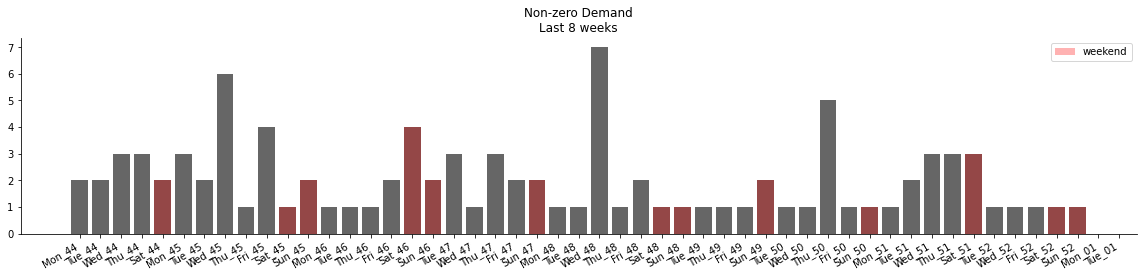

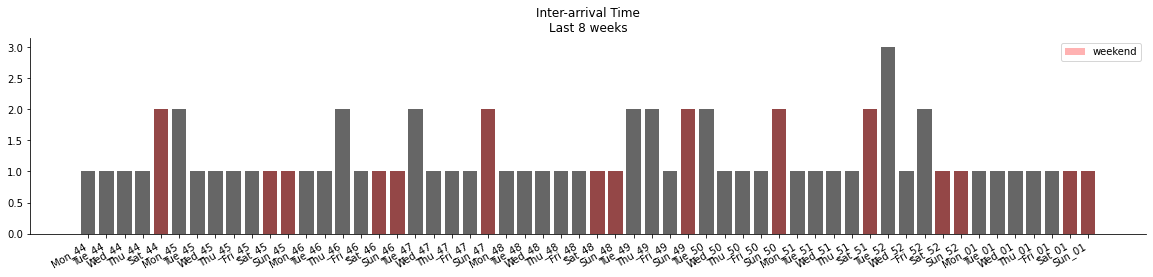

In [203]:
n_weeks=8
n=7*n_weeks

wkd_idx = np.where((nonzero_d_weekday[-n:].str.startswith("Sat")) |
                                           (nonzero_d_weekday[-n:].str.startswith("Sun")))[0]

fig = plt.figure(figsize=(20,4))
plt.bar(nonzero_d_weekday[-n:], q[-n:], color="black", alpha=0.6)
plt.bar(nonzero_d_weekday[-n:].iloc[wkd_idx], q[-n:][wkd_idx], color="red", alpha=0.3, label="weekend")
plt.title(f"Non-zero Demand\nLast {n_weeks} weeks")
plt.legend(loc='upper right')
fig.autofmt_xdate()
plt.show()


fig = plt.figure(figsize=(20,4))
plt.bar(nonzero_d_weekday[-n:], a[-n:], color="black", alpha=0.6)
plt.bar(nonzero_d_weekday[-n:].iloc[wkd_idx], a[-n:][wkd_idx], color="red", alpha=0.3, label="weekend")
plt.title(f"Inter-arrival Time\nLast {n_weeks} weeks")
plt.legend(loc='upper right')
fig.autofmt_xdate()
plt.show()